In [1]:
!pip install pydot
import pydot


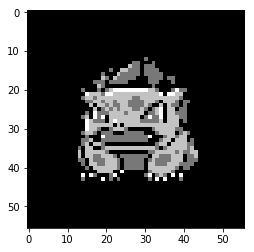

(56, 56, 3)


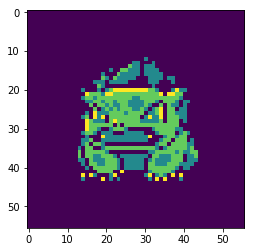

In [28]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
import os
img = image.load_img("./imgs/001_pika.png")
img = np.array(img)

plt.imshow(img)
plt.show()
print(img.shape)
plt.imshow(img[:,:,1])
plt.show()

In [26]:
# 画像を読み込む。
X = []
names = os.listdir("./imgs")

for name in names:
    tmp  = image.load_img("./imgs/"+ name)
    tmp = np.array(tmp)
    X.append(tmp)

# 画像データ生成器を作成する。
params = {
    'rotation_range': 20,
    'width_shift_range': 0.4
}
datagen = image.ImageDataGenerator(**params)


# ミニバッチを生成するジェネレーターを作成する。
gen = datagen.flow(X, batch_size=16)




# Python ジェネレーターで9枚生成して、表示する。
plt.figure(figsize=(10, 8))
for i in range(9):
    batches = next(gen)  # (NumBatches, Height, Width, Channels) の4次元データを返す。
    # 画像として表示するため、3次元データにし、float から uint8 にキャストする。
    gen_img = batches[0]#.astype(np.uint8)
    gen_img = gen_img[:,:,0]
    print(gen_img.shape)
    plt.subplot(3, 3, i + 1)
    plt.imshow(gen_img)
    plt.axis('off')
plt.show()

ValueError: ('Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape', (56, 56, 3))

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Convolution2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Flatten, Dropout
import math
import numpy as np

def generator_model():
    model = Sequential()
    model.add(Dense(input_dim=100, output_dim=1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(128*7*7))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Reshape((128, 7, 7), input_shape=(128*7*7,)))
    model.add(UpSampling2D((2, 2)))
    model.add(Convolution2D(64, 5, 5, border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    model.add(Convolution2D(32, 5, 5, border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    model.add(Convolution2D(1, 5, 5, border_mode='same'))
    model.add(Activation('tanh'))
    return model

def discriminator_model():
    model = Sequential()
    model.add(Convolution2D(64, 5, 5,
                            subsample=(2, 2),
                            border_mode='same',
                            input_shape=(1, 56, 56)))
    model.add(LeakyReLU(0.2))
    model.add(Convolution2D(128, 5, 5, subsample=(2, 2)))
    model.add(LeakyReLU(0.2))
    comp =  model.compile(optimizer="adam",loss = "mse")
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    model.add(Activation('sigmoid'))
    return model


def combine_images(generated_images):
    total = generated_images.shape[0]
    cols = int(math.sqrt(total))
    rows = math.ceil(float(total)/cols)
    width, height = generated_images.shape[2:]
    combined_image = np.zeros((height*rows, width*cols),
                              dtype=generated_images.dtype)

    for index, image in enumerate(generated_images):
        i = int(index/cols)
        j = index % cols
        combined_image[width*i:width*(i+1), height*j:height*(j+1)] = image[0, :, :]
    return combined_image


In [6]:
import os
from keras.datasets import mnist
from keras.optimizers import Adam
from PIL import Image

BATCH_SIZE = 10
NUM_EPOCH = 1
GENERATED_IMAGE_PATH = 'generated_images/' # 生成画像の保存先

def train():
    
    X_train = (X_train.astype(np.float32) - 127.5)/127.5
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
    discriminator = discriminator_model()
    d_opt = Adam(lr=1e-5, beta_1=0.1)
    discriminator.compile(loss='binary_crossentropy', optimizer=d_opt)

    # generator+discriminator （discriminator部分の重みは固定）
    discriminator.trainable = False
    generator = generator_model()
    dcgan = Sequential([generator, discriminator])
    g_opt = Adam(lr=2e-4, beta_1=0.5)
    dcgan.compile(loss='binary_crossentropy', optimizer=g_opt)

    num_batches = int(X_train.shape[0] / BATCH_SIZE)
    print('Number of batches:', num_batches)
    for epoch in range(NUM_EPOCH):

        for index in range(num_batches):
            noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(BATCH_SIZE)])
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = generator.predict(noise, verbose=0)

            # 生成画像を出力
            if index % 500 == 0:
                image = combine_images(generated_images)
                image = image*127.5 + 127.5
                if not os.path.exists(GENERATED_IMAGE_PATH):
                    os.mkdir(GENERATED_IMAGE_PATH)
                Image.fromarray(image.astype(np.uint8))\
                    .save(GENERATED_IMAGE_PATH+"%04d_%04d.png" % (epoch, index))

            # discriminatorを更新
            X = np.concatenate((image_batch, generated_images))
            y = [1]*BATCH_SIZE + [0]*BATCH_SIZE
            d_loss = discriminator.train_on_batch(X, y)

            # generatorを更新
            noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(BATCH_SIZE)])
            g_loss = dcgan.train_on_batch(noise, [1]*BATCH_SIZE)
            print("epoch: %d, batch: %d, g_loss: %f, d_loss: %f" % (epoch, index, g_loss, d_loss))

        generator.save_weights('generator.h5')
        discriminator.save_weights('discriminator.h5')

train()

Instructions for updating:
Colocations handled automatically by placer.


/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(1, 28, 28..., strides=(2, 2), padding="same")`
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), strides=(2, 2))`


ValueError: Negative dimension size caused by subtracting 5 from 1 for 'conv2d_2/convolution' (op: 'Conv2D') with input shapes: [?,1,14,64], [5,5,64,128].

In [ ]:
model = Sequential()
model.add(Convolution2D(64, 5, 5,
                        subsample=(2, 2),
                        border_mode='same',
                        input_shape=(1, 28, 28)))
model.add(LeakyReLU(0.2))
model.add(Convolution2D(128, 5, 5, subsample=(2, 2)))
model.add(LeakyReLU(0.2))
model.compile(optimizer="adam", loss='mean_squared_error', )

(X_train, y_train), (_, _) = mnist.load_data()
X_train = (X_train[:10].astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])

model.fit(X_train, batch_size=1, epochs=1,validation_steps = 1)

In [12]:
X_train.shape

(10, 1, 28, 28)